In [1]:
import gc
import os
import sys
import json
import psutil
import logging
import warnings
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

sys.path.append("..")

from src.data import DataExtractor, DataProcessor

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:,.4f}".format)

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

logger.info("Environment ready — pandas: %s", pd.__version__)

2025-10-15 20:59:18,005 - INFO - Environment ready — pandas: 2.3.3


In [2]:
symbol = "BTCUSDT"  # e.g., BTCUSDT, ETHUSDT
data_type = "klines"  # source archive type label used in filenames

data_folder = Path.cwd().parent / "data"
downloaded_folder = data_folder / "downloaded"
raw_folder = data_folder / "raw"
symbol_folder = raw_folder / symbol / data_type
symbol_folder.mkdir(parents=True, exist_ok=True)

# print(f"Symbol: {symbol}, data folder: {symbol_folder}")


### Data extraction and chunking

This section extracts CSV files from downloaded ZIP archives, converts rows to typed columns and slices the resulting stream into fixed-size Parquet parts. Each part is sized to balance on-disk compactness and in-memory loading costs so downstream analyses can either load parts selectively or concatenate them into a single DataFrame when resources allow.

The code is written as reusable functions so you can re-run extraction, inspect parts, or re-chunk quickly during experiments.

In [3]:
ROWS = 250_000  # for klines
# ROWS = 1_000_000  # target rows per parquet part

def get_cols_and_dtypes_by_df(df: pd.DataFrame):
	"""Get column names and dtypes from a DataFrame."""
	cols = df.columns.tolist()
	dtypes = df.dtypes.apply(lambda x: x.name).tolist()
	return cols, dtypes

# parts = DataExtractor.extract_and_chunk(symbol, data_type, ROWS, time_col="create_time")

### Resource usage inspection

Quickly measure on-disk size, the DataFrame's logical memory footprint and the RSS delta observed when reading each Parquet part. This helps decide whether you can safely load all data into RAM or whether you must adopt chunked/out-of-core processing. The helper below returns a concise summary and prints per-part metrics.

In [4]:
def sizeof_fmt(num, suffix="B"):
	for unit in ["", "Ki", "Mi", "Gi", "Ti"]:
		if abs(num) < 1024.0:
			return f"{num:3.1f}{unit}{suffix}"
		num /= 1024.0
	return f"{num:.1f}Pi{suffix}"


def rss_bytes():
	return psutil.Process(os.getpid()).memory_info().rss


def analyze_parts(parts):
	"""Return summary dict and print per-part metrics."""
	if not parts:
		print(f"No parquet parts found in {symbol_folder}")
		return {}

	rows = []
	disk_sizes = []
	logical_mem = []
	rss_deltas = []
	overheads = []

	for p in parts:
		size_on_disk = p.stat().st_size
		before = rss_bytes()
		df = pd.read_parquet(p, engine="pyarrow")
		after = rss_bytes()
		row_count = len(df)
		mem_bytes = df.memory_usage(deep=True).sum()
		delta_rss = max(after - before, 0)
		overhead = delta_rss / mem_bytes if mem_bytes else 0

		rows.append(row_count)
		disk_sizes.append(size_on_disk)
		logical_mem.append(mem_bytes)
		rss_deltas.append(delta_rss)
		overheads.append(overhead)

		print(f"{p.name}: rows={row_count:,}, disk={sizeof_fmt(size_on_disk)}, ")
		print(f"  logical_mem={sizeof_fmt(mem_bytes)}, rss_delta={sizeof_fmt(delta_rss)}, overhead={overhead:,.2f}x")

		del df
		gc.collect()

	total_rows = sum(rows)
	total_disk = sum(disk_sizes)
	total_logical = sum(logical_mem)
	total_rss = sum(rss_deltas)
	avg_overhead = sum(overheads) / len(overheads) if overheads else 0
	avg_mem_per_row = total_rss / total_rows if total_rows else 0
	est_total_single_df = int(total_rss * 1.10)

	summary = {
		"parts": len(parts),
		"total_rows": total_rows,
		"total_disk": total_disk,
		"total_logical": total_logical,
		"total_rss": total_rss,
		"avg_overhead": avg_overhead,
		"avg_mem_per_row": avg_mem_per_row,
		"estimated_memory_one_df": est_total_single_df,
	}

	print("\nSUMMARY")
	print(f"parts: {summary['parts']}")
	print(f"total rows: {summary['total_rows']:,}")
	print(f"total disk size: {sizeof_fmt(summary['total_disk'])}")
	print(f"total logical mem: {sizeof_fmt(summary['total_logical'])}")
	print(f"total rss delta: {sizeof_fmt(summary['total_rss'])}")
	print(f"avg overhead factor: {summary['avg_overhead']:.2f}x")
	print(f"avg mem per row: {sizeof_fmt(summary['avg_mem_per_row'])}/row")
	print(f"estimated memory to load as one DataFrame (≈+10% overhead): {sizeof_fmt(summary['estimated_memory_one_df'])}")

	return summary


parts = sorted(symbol_folder.glob("part*.parquet"))
summary = analyze_parts(parts)


part0001.parquet: rows=250,000, disk=15.8MiB, 
  logical_mem=22.9MiB, rss_delta=119.2MiB, overhead=5.21x
part0002.parquet: rows=250,000, disk=15.6MiB, 
  logical_mem=22.9MiB, rss_delta=67.7MiB, overhead=2.96x
part0003.parquet: rows=250,000, disk=16.6MiB, 
  logical_mem=22.9MiB, rss_delta=52.1MiB, overhead=2.28x
part0004.parquet: rows=250,000, disk=16.6MiB, 
  logical_mem=22.9MiB, rss_delta=64.0MiB, overhead=2.80x
part0005.parquet: rows=250,000, disk=16.1MiB, 
  logical_mem=22.9MiB, rss_delta=58.6MiB, overhead=2.56x
part0006.parquet: rows=250,000, disk=14.4MiB, 
  logical_mem=22.9MiB, rss_delta=48.0MiB, overhead=2.10x
part0007.parquet: rows=250,000, disk=14.4MiB, 
  logical_mem=22.9MiB, rss_delta=50.0MiB, overhead=2.19x
part0008.parquet: rows=250,000, disk=13.7MiB, 
  logical_mem=22.9MiB, rss_delta=52.0MiB, overhead=2.27x
part0009.parquet: rows=250,000, disk=15.3MiB, 
  logical_mem=22.9MiB, rss_delta=66.0MiB, overhead=2.88x
part0010.parquet: rows=250,000, disk=14.7MiB, 
  logical_mem=22

### Continuity checks for time-series integrity

Confirm the 1-minute cadence of the `open_time` column across and between Parquet parts. The checks detect duplicates, non-monotonic steps and missing rows; they produce a compact issues table suitable for filtering and further remediation (e.g., interpolation or dropping corrupted segments). The function below returns a DataFrame of issues.

In [5]:
df = pd.concat([pd.read_parquet(p, engine="pyarrow") for p in parts], ignore_index=True)
df = DataProcessor.sort_by_time(df, time_col="open_time")
res = DataProcessor.check_time_continuity(df, time_col="open_time", delta_ms=60_000)

In [6]:
print("Missing intervals (if any):", res["missing"])
print("Duplicate intervals (if any):", res["duplicate"])
print("Non-monotonic intervals (if any):", res["too_close"])

Missing intervals (if any): []
Duplicate intervals (if any): []
Non-monotonic intervals (if any): []


In [7]:
# res = DataProcessor.split_data_time_based(df, "ignore", test_size=0.20, val_size=0.20)
display(df.head(3).iloc[:, :5])

from src.data import DataPipelineConfig

# cfg = DataPipelineConfig(
#     numerical_std=FeatureScalingConfig(
#         features=["high", "close"],
#         impute_strategy="median",
# 		scaler="standard",
# 	)
# ).save(symbol_folder / "pipeline_config.json")
cfg = DataPipelineConfig.load(symbol_folder / "pipeline_config.json")
pipeline = DataProcessor.build_pipeline(cfg)
pipeline.fit(df)
processed = DataProcessor.process_data(df, pipeline)
processed.head(3).iloc[:, :5]



,open_time,open,high,low,close
0,1577836800000,"7,189.4300","7,190.5200","7,177.0000","7,182.4400"
1,1577836860000,"7,182.4300","7,182.4400","7,178.7500","7,179.0100"
2,1577836920000,"7,179.0100","7,179.0100","7,175.2500","7,177.9300"


2025-10-15 20:59:19,940 - DEBUG - Processing data with pipeline: 
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_std',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['high', 'close'])]))])


,num_std__high,num_std__close,remainder__open_time,remainder__open,remainder__low
0,-1.2540,-1.2539,1577836800000,"7,189.4300","7,177.0000"
1,-1.2542,-1.2541,1577836860000,"7,182.4300","7,178.7500"
2,-1.2544,-1.2541,1577836920000,"7,179.0100","7,175.2500"


,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1577836800000,"7,189.4300","7,190.5200","7,177.0000","7,182.4400",246.0920,1577836859999,"1,767,430.1612",336,46.6300,"334,813.1982",0
1,1577836860000,"7,182.4300","7,182.4400","7,178.7500","7,179.0100",70.9090,1577836919999,"509,145.7848",140,32.5970,"234,063.2788",0
2,1577836920000,"7,179.0100","7,179.0100","7,175.2500","7,177.9300",99.4200,1577836979999,"713,539.5535",148,16.3110,"117,066.9212",0
3,1577836980000,"7,177.7700","7,182.6000","7,177.0000","7,181.1100",69.3300,1577837039999,"497,793.3593",104,43.7230,"313,920.0298",0
4,1577837040000,"7,179.1000","7,179.1000","7,172.9400","7,175.2500",97.3680,1577837099999,"698,627.3938",193,36.6160,"262,734.6900",0



========== STATS ==========



,count,mean,std,min,25%,50%,75%,max
open,"3,039,840.0000","45,232.3083","30,344.0976","3,706.9600","21,288.9750","38,379.9050","62,200.7850","126,086.7000"
high,"3,039,840.0000","45,252.8228","30,353.3469","3,779.0000","21,298.9000","38,407.1750","62,230.3775","126,208.5000"
low,"3,039,840.0000","45,211.8145","30,334.8032","3,621.8100","21,278.9000","38,351.5900","62,173.5000","126,030.0000"
close,"3,039,840.0000","45,232.3420","30,344.1128","3,706.9600","21,288.9000","38,379.9000","62,200.8500","126,086.8000"
volume,"3,039,840.0000",238.4283,462.6250,0.0000,57.9960,117.7660,248.5870,"40,256.9870"
quote_volume,"3,039,840.0000","9,166,621.3329","17,499,397.3087",0.0000,"1,986,646.1545","4,461,208.6482","9,737,787.9382","1,434,875,561.7248"
count,"3,039,840.0000","2,199.6011","3,185.2818",0.0000,719.0000,"1,348.0000","2,504.0000","263,775.0000"
taker_buy_volume,"3,039,840.0000",118.8243,241.9321,0.0000,25.5410,55.5670,123.0143,"19,093.4830"
taker_buy_quote_volume,"3,039,840.0000","4,559,261.2986","9,199,049.6110",0.0000,"869,999.2157","2,082,478.2570","4,764,898.1894","755,719,368.2600"
ignore,"3,039,840.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000



========== INFO ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039840 entries, 0 to 3039839
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   open_time               int64  
 1   open                    float64
 2   high                    float64
 3   low                     float64
 4   close                   float64
 5   volume                  float64
 6   close_time              int64  
 7   quote_volume            float64
 8   count                   int64  
 9   taker_buy_volume        float64
 10  taker_buy_quote_volume  float64
 11  ignore                  int64  
dtypes: float64(8), int64(4)
memory usage: 278.3 MB

========== MISSING STATS ==========



,count,percent
open_time,0,0.0000
open,0,0.0000
high,0,0.0000
low,0,0.0000
close,0,0.0000
volume,0,0.0000
close_time,0,0.0000
quote_volume,0,0.0000
count,0,0.0000
taker_buy_volume,0,0.0000



========== DUPLICATES STATS ==========



,count,percent
open_time,0,0.0000
open,1569934,51.6500
high,1690925,55.6300
low,1688407,55.5400
close,1568317,51.5900
volume,2328930,76.6100
close_time,0,0.0000
quote_volume,282,0.0100
count,3009851,99.0100
taker_buy_volume,2559571,84.2000



========== TOP 5 MOST FREQUENT VALUES ==========

Column: open


,Value,Count,Percent
0,"29,200.0000",79,0.0000
1,"69,566.1000",75,0.0000
2,"16,820.0000",70,0.0000
3,"30,300.0000",70,0.0000
4,"29,400.0000",67,0.0000


Column: high


,Value,Count,Percent
0,"37,000.0000",142,0.0000
1,"9,320.0000",136,0.0000
2,"39,000.0000",132,0.0000
3,"63,000.0000",131,0.0000
4,"61,000.0000",131,0.0000


Column: low


,Value,Count,Percent
0,"60,800.0000",140,0.0000
1,"47,100.0000",136,0.0000
2,"62,900.0000",128,0.0000
3,"57,750.0000",127,0.0000
4,"43,600.0000",124,0.0000


Column: close


,Value,Count,Percent
0,"69,566.1000",78,0.0000
1,"19,140.0000",73,0.0000
2,"29,400.0000",72,0.0000
3,"16,820.0000",71,0.0000
4,"29,200.0000",70,0.0000


Column: volume


,Value,Count,Percent
0,0.0000,273,0.0100
1,31.0010,38,0.0000
2,48.7220,37,0.0000
3,33.6340,35,0.0000
4,26.1480,34,0.0000


Column: quote_volume


,Value,Count,Percent
0,0.0000,273,0.0100
1,"3,594,099.8827",2,0.0000
2,"2,076,476.9489",2,0.0000
3,"10,894,848.5074",2,0.0000
4,"2,860,396.2994",2,0.0000


Column: count


,Value,Count,Percent
0,760,1395,0.0500
1,837,1390,0.0500
2,853,1387,0.0500
3,735,1384,0.0500
4,797,1379,0.0500


Column: taker_buy_volume


,Value,Count,Percent
0,0.0000,307,0.0100
1,21.8990,61,0.0000
2,18.9250,58,0.0000
3,15.9260,58,0.0000
4,18.5280,58,0.0000


Column: taker_buy_quote_volume


,Value,Count,Percent
0,0.0000,307,0.0100
1,"2,512,650.5180",2,0.0000
2,"490,354.4673",2,0.0000
3,"1,561,163.1917",2,0.0000
4,"2,712,650.8986",2,0.0000


Column: ignore


,Value,Count,Percent
0,0,3039840,100.0000


2025-10-15 20:59:29,937 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-15 20:59:29,937 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-15 20:59:29,940 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-10-15 20:59:29,940 - DEBUG - findfont: score(FontEntry(fname='/home/bloodrain/Desktop/Deep_Learning/Crypto_Market_Analyzer/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-10-15 20:59:29,940 - DEBUG - findfont: score(FontEntry(fname='/home/bloodrain/Desktop/Deep_Learning/Crypto_Market_Analyzer/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-10-15 20

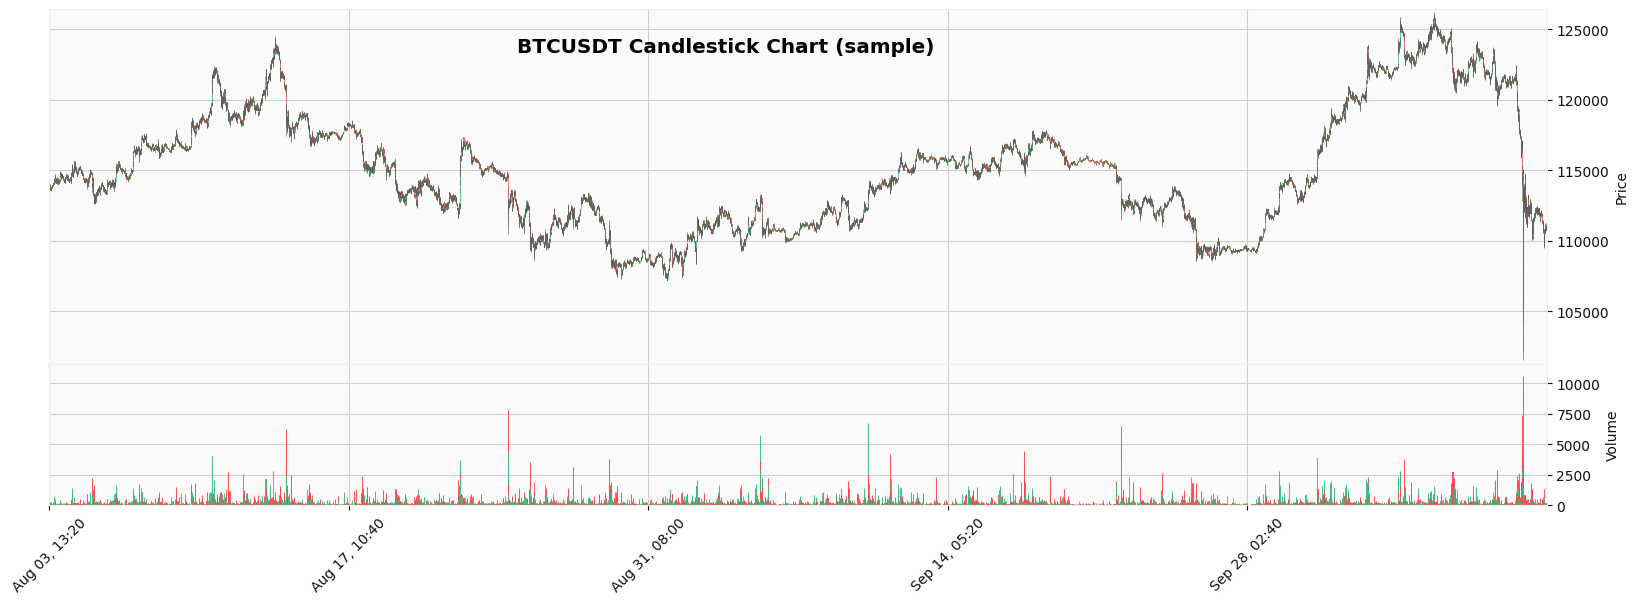

In [8]:
if df.empty:
	print("DataFrame is empty — ensure parts exist or run extraction.")
else:
	display(df.head())

	df_without_time = df.drop(["open_time", "close_time"], axis=1, errors="ignore")
	print(f"\n{'='*10} STATS {'='*10}\n")
	display(df_without_time.describe().T)

	print(f"\n{'='*10} INFO {'='*10}\n")
	df.info()

	print(f"\n{'='*10} MISSING STATS {'='*10}\n")
	missing_per_column = pd.DataFrame({
		"count": df.isnull().sum(),
		"percent": (df.isnull().sum() / df.shape[0] * 100).round(2)
	})
	display(missing_per_column)

	print(f"\n{'='*10} DUPLICATES STATS {'='*10}\n")
	duplicates_per_column = pd.DataFrame({
		"count": df.shape[0] - df.nunique(),
		"percent": ((df.shape[0] - df.nunique()) / df.shape[0] * 100).round(2)
	})
	display(duplicates_per_column)

	print(f"\n{'='*10} TOP 5 MOST FREQUENT VALUES {'='*10}\n")
	for col in df.columns:
		if df[col].nunique() == df.shape[0]:
			continue
		counts = df[col].value_counts(normalize=False).head(5)
		percents = (df[col].value_counts(normalize=True).head(5) * 100).round(2)
		combined = pd.DataFrame({
			"Value": counts.index,
			"Count": counts.values,
			"Percent": percents.values
		})
		print(f"Column: {col}")
		display(combined)

	sample = df if len(df) <= 100_000 else df.iloc[-100_000:]
	sample["Date"] = pd.to_datetime(sample["open_time"], unit="ms")
	sample = sample[["Date", "open", "high", "low", "close", "volume"]].set_index("Date")
	mpf.plot(
		sample,
		type="candle",
		style="yahoo",
		title=f"{symbol} Candlestick Chart (sample)",
		ylabel="Price",
		ylabel_lower="Volume",
		volume=True,
		figratio=(12, 4),
		tight_layout=True
	)

	summary = {
		"symbol": symbol,
		"parts": len(parts),
		"rows": int(df.shape[0]),
		"first_time": str(pd.to_datetime(int(df.open_time.min()), unit="ms")) if not df.empty else None,
		"last_time": str(pd.to_datetime(int(df.open_time.max()), unit="ms")) if not df.empty else None,
	}
	summary
